# Long Short-Term Memory (LSTM)
:label:`sec_lstm`


Shortly after the first Elman-style RNNs were trained using backpropagation 
:cite:`elman1990finding`, the problems of learning long-term dependencies
(owing to vanishing and exploding gradients)
became salient, with Bengio and Hochreiter 
discussing the problem
:cite:`bengio1994learning,Hochreiter.Bengio.Frasconi.ea.2001`.
Hochreiter had articulated this problem as early 
as 1991 in his Master's thesis, although the results 
were not widely known because the thesis was written in German.
While gradient clipping helps with exploding gradients, 
handling vanishing gradients appears 
to require a more elaborate solution. 
One of the first and most successful techniques 
for addressing vanishing gradients 
came in the form of the long short-term memory (LSTM) model 
due to :citet:`Hochreiter.Schmidhuber.1997`. 
LSTMs resemble standard recurrent neural networks 
but here each ordinary recurrent node
is replaced by a *memory cell*.
Each memory cell contains an *internal state*,
i.e., a node with a self-connected recurrent edge of fixed weight 1,
ensuring that the gradient can pass across many time steps 
without vanishing or exploding.

The term "long short-term memory" comes from the following intuition.
Simple recurrent neural networks 
have *long-term memory* in the form of weights.
The weights change slowly during training, 
encoding general knowledge about the data.
They also have *short-term memory*
in the form of ephemeral activations,
which pass from each node to successive nodes.
The LSTM model introduces an intermediate type of storage via the memory cell.
A memory cell is a composite unit, 
built from simpler nodes 
in a specific connectivity pattern,
with the novel inclusion of multiplicative nodes.

In [1]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN

  Activating project at `/workspace/d2l-julia/d2lai`
[ Info: Precompiling d2lai [749b8817-cd67-416c-8a57-830ea19f3cc4] (cache misses: include_dependency fsize change (2))


## Gated Memory Cell

Each memory cell is equipped with an *internal state*
and a number of multiplicative gates that determine whether
(i) a given input should impact the internal state (the *input gate*),
(ii) the internal state should be flushed to $0$ (the *forget gate*),
and (iii) the internal state of a given neuron 
should be allowed to impact the cell's output (the *output* gate). 


### Gated Hidden State

The key distinction between vanilla RNNs and LSTMs
is that the latter support gating of the hidden state.
This means that we have dedicated mechanisms for
when a hidden state should be *updated* and
also for when it should be *reset*.
These mechanisms are learned and they address the concerns listed above.
For instance, if the first token is of great importance
we will learn not to update the hidden state after the first observation.
Likewise, we will learn to skip irrelevant temporary observations.
Last, we will learn to reset the latent state whenever needed.
We discuss this in detail below.

### Input Gate, Forget Gate, and Output Gate

The data feeding into the LSTM gates are
the input at the current time step and
the hidden state of the previous time step,
as illustrated in :numref:`fig_lstm_0`.
Three fully connected layers with sigmoid activation functions
compute the values of the input, forget, and output gates.
As a result of the sigmoid activation,
all values of the three gates
are in the range of $(0, 1)$.
Additionally, we require an *input node*,
typically computed with a *tanh* activation function. 
Intuitively, the *input gate* determines how much
of the input node's value should be added 
to the current memory cell internal state.
The *forget gate* determines whether to keep
the current value of the memory or flush it. 
And the *output gate* determines whether 
the memory cell should influence the output
at the current time step. 


![Computing the input gate, the forget gate, and the output gate in an LSTM model.](../img/lstm-0.svg)
:label:`fig_lstm_0`

Mathematically, suppose that there are $h$ hidden units, 
the batch size is $n$, and the number of inputs is $d$.
Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
and the hidden state of the previous time step 
is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. 
Correspondingly, the gates at time step $t$
are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, 
the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, 
and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. 
They are calculated as follows:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xi}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hi}} + \mathbf{b}_\textrm{i}),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xf}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hf}} + \mathbf{b}_\textrm{f}),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xo}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{ho}} + \mathbf{b}_\textrm{o}),
\end{aligned}
$$

where $\mathbf{W}_{\textrm{xi}}, \mathbf{W}_{\textrm{xf}}, \mathbf{W}_{\textrm{xo}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hi}}, \mathbf{W}_{\textrm{hf}}, \mathbf{W}_{\textrm{ho}} \in \mathbb{R}^{h \times h}$ are weight parameters 
and $\mathbf{b}_\textrm{i}, \mathbf{b}_\textrm{f}, \mathbf{b}_\textrm{o} \in \mathbb{R}^{1 \times h}$ are bias parameters.
Note that broadcasting 
(see :numref:`subsec_broadcasting`)
is triggered during the summation.
We use sigmoid functions 
(as introduced in :numref:`sec_mlp`) 
to map the input values to the interval $(0, 1)$.


### Input Node

Next we design the memory cell. 
Since we have not specified the action of the various gates yet, 
we first introduce the *input node* 
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$.
Its computation is similar to that of the three gates described above, 
but uses a $\tanh$ function with a value range for $(-1, 1)$ as the activation function. 
This leads to the following equation at time step $t$:

$$\tilde{\mathbf{C}}_t = \textrm{tanh}(\mathbf{X}_t \mathbf{W}_{\textrm{xc}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hc}} + \mathbf{b}_\textrm{c}),$$

where $\mathbf{W}_{\textrm{xc}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\textrm{hc}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_\textrm{c} \in \mathbb{R}^{1 \times h}$ is a bias parameter.

A quick illustration of the input node is shown in :numref:`fig_lstm_1`.

![Computing the input node in an LSTM model.](../img/lstm-1.svg)
:label:`fig_lstm_1`


### Memory Cell Internal State

In LSTMs, the input gate $\mathbf{I}_t$ governs 
how much we take new data into account via $\tilde{\mathbf{C}}_t$ 
and the forget gate $\mathbf{F}_t$ addresses 
how much of the old cell internal state $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. 
Using the Hadamard (elementwise) product operator $\odot$
we arrive at the following update equation:

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

If the forget gate is always 1 and the input gate is always 0, 
the memory cell internal state $\mathbf{C}_{t-1}$
will remain constant forever, 
passing unchanged to each subsequent time step.
However, input gates and forget gates
give the model the flexibility of being able to learn 
when to keep this value unchanged
and when to perturb it in response 
to subsequent inputs. 
In practice, this design alleviates the vanishing gradient problem,
resulting in models that are much easier to train,
especially when facing datasets with long sequence lengths. 

We thus arrive at the flow diagram in :numref:`fig_lstm_2`.

![Computing the memory cell internal state in an LSTM model.](../img/lstm-2.svg)

:label:`fig_lstm_2`


### Hidden State

Last, we need to define how to compute the output
of the memory cell, i.e., the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$, as seen by other layers. 
This is where the output gate comes into play.
In LSTMs, we first apply $\tanh$ to the memory cell internal state
and then apply another point-wise multiplication,
this time with the output gate.
This ensures that the values of $\mathbf{H}_t$ 
are always in the interval $(-1, 1)$:

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$


Whenever the output gate is close to 1, 
we allow the memory cell internal state to impact the subsequent layers uninhibited,
whereas for output gate values close to 0,
we prevent the current memory from impacting other layers of the network
at the current time step. 
Note that a memory cell can accrue information 
across many time steps without impacting the rest of the network
(as long as the output gate takes values close to 0),
and then suddenly impact the network at a subsequent time step
as soon as the output gate flips from values close to 0
to values close to 1. :numref:`fig_lstm_3` has a graphical illustration of the data flow.

![Computing the hidden state in an LSTM model.](../img/lstm-3.svg)
:label:`fig_lstm_3`



## Implementation from Scratch

Now let's implement an LSTM from scratch.
As same as the experiments in :numref:`sec_rnn-scratch`,
we first load *The Time Machine* dataset.

### Initializing Model Parameters

Next, we need to define and initialize the model parameters. 
As previously, the hyperparameter `num_hiddens` 
dictates the number of hidden units.
We initialize weights following a Gaussian distribution
with 0.01 standard deviation, 
and we set the biases to 0.


In [5]:
struct LSTMScratch{W, A} <: AbstractModel 
    w::W
    args::A
end 
Flux.@layer LSTMScratch trainable = (w,)

In [6]:
function LSTMScratch(num_inputs::Int, num_hiddens::Int; sigma = 0.1)
    init_weights() = randn(num_hiddens, num_inputs).*sigma, randn(num_hiddens, num_hiddens).*sigma, zeros(num_hiddens)
    W_ix, W_ih, b_i = init_weights() # input gate
    W_fx, W_fh, b_f = init_weights() # forget gate
    W_cx, W_ch, b_c = init_weights() # input node
    W_ox, W_oh, b_o = init_weights()

    w = (input_gate = d2lai.construct_nt_args(;W_ix, W_ih, b_i),
         forget_gate = d2lai.construct_nt_args(; W_fx, W_fh, b_f),
         input_node = d2lai.construct_nt_args(;W_cx, W_ch, b_c),
         output_gate = d2lai.construct_nt_args(;W_ox, W_oh, b_o)
    )
    args = d2lai.construct_nt_args(; num_inputs, num_hiddens, sigma)
    LSTMScratch(w, args)
end

LSTMScratch

In [7]:
function (m::LSTMScratch)(x, state = nothing)
    batchsize = size(x, 3)
    device = isa(x, CuArray) ? gpu : cpu 
    H, C = if isnothing(state)
        zeros(m.args.num_hiddens, batchsize), zeros(m.args.num_hiddens, batchsize) 
    else
        state
    end |> device

    outputs = map(eachslice(x; dims = 2)) do x_ 
        It = sigmoid.(m.w.input_gate.W_ix*x_ + m.w.input_gate.W_ih*H .+ m.w.input_gate.b_i)
        Ft = sigmoid.(m.w.forget_gate.W_fx*x_ + m.w.forget_gate.W_fh*H .+ m.w.forget_gate.b_f)
        Ot = sigmoid.(m.w.output_gate.W_ox*x_ + m.w.output_gate.W_oh*H .+ m.w.output_gate.b_o)
        C_tilde = tanh.(m.w.input_node.W_cx*x_ + m.w.input_node.W_ch*H .+ m.w.input_node.b_c)
        C = Ft.*C + It.*C_tilde
        H = Ot.*C
        return H
    end
    outputs = stack(outputs)
    permutedims(outputs, [1,3,2]), (H,C)
end

### Training and Prediction

Let's train an LSTM model by instantiating the `RNNLMScratch` class from :numref:`sec_rnn-scratch`.


In [8]:
data = d2lai.TimeMachine(1024, 32) |> f64
num_hiddens = 32
lstm = LSTMScratch(length(data.vocab), num_hiddens)
model = RNNLMScratch(lstm, length(data.vocab)) |> f64

RNNLMScratch(
  LSTMScratch(
    (W_ix = [0.08747171542425301 -0.17341179478720958 … -0.06726800252203806 0.09367294373942317; -0.1452824044577879 0.12619551779995467 … -0.09895119556199267 0.010863879061412557; … ; -0.04473087731072691 -0.09172165627921565 … -0.022918508423614457 0.12640761448798024; 0.044891806895076894 0.1253085614641499 … 0.13964047920846456 0.04759282998431221], W_ih = [0.00198311320890812 0.06285866923421234 … 0.1181754137313053 0.022546301070249433; -0.11826559391442358 -0.02407909507971443 … 0.10119098908374068 -0.09650097487588047; … ; -0.1636589338274944 0.17372744913318205 … 0.05804939516927729 -0.017811349706691525; -0.055622201558758556 -0.02674223288341316 … -0.012510227028076538 -0.07420678957704421], b_i = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),  # 1_952 parameters
    (W_fx = [-0.03990545908452857 -0.067809551088846 … -0.10866316208637067 0.09450208536139496; 0.104632485712098 -0.0713691

[ Info: Train Loss: 2.8577464, Val Loss: 2.8570354
[ Info: Train Loss: 2.789548, Val Loss: 2.7877047
[ Info: Train Loss: 2.688144, Val Loss: 2.6732988
[ Info: Train Loss: 2.5377173, Val Loss: 2.537118
[ Info: Train Loss: 2.4538963, Val Loss: 2.4457486
[ Info: Train Loss: 2.3772397, Val Loss: 2.3949955
[ Info: Train Loss: 2.3360584, Val Loss: 2.3654156
[ Info: Train Loss: 2.2909172, Val Loss: 2.3251545
[ Info: Train Loss: 2.2559114, Val Loss: 2.3191686
[ Info: Train Loss: 2.2344718, Val Loss: 2.2964644
[ Info: Train Loss: 2.1931727, Val Loss: 2.2701557
[ Info: Train Loss: 2.168284, Val Loss: 2.2416053
[ Info: Train Loss: 2.1241865, Val Loss: 2.224526
[ Info: Train Loss: 2.1009102, Val Loss: 2.1999269
[ Info: Train Loss: 2.0752017, Val Loss: 2.1708565
[ Info: Train Loss: 2.0330355, Val Loss: 2.1414955
[ Info: Train Loss: 2.0177925, Val Loss: 2.1233914
[ Info: Train Loss: 1.9999425, Val Loss: 2.1197312
[ Info: Train Loss: 1.9709194, Val Loss: 2.0945277
[ Info: Train Loss: 1.9374853, Val L

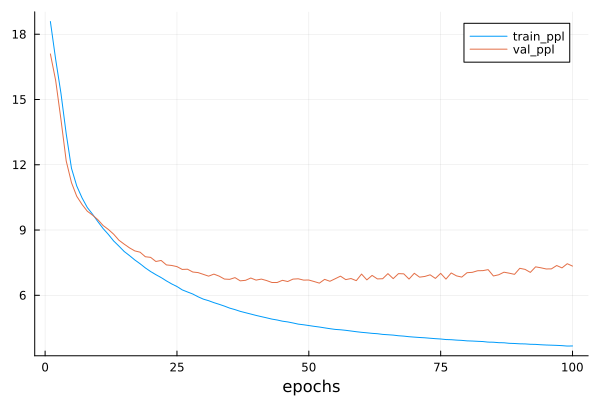

In [9]:
opt = Descent(1.)
trainer = Trainer(model, data, opt; max_epochs = 100, gpu = true, board_yscale = :identity, gradient_clip_val = 1.)
m = d2lai.fit(trainer);

In [10]:
prefix = "it has"
d2lai.prediction(prefix, m[1], data.vocab, 20)

"it has and some that is al"

## Concise Implementation

Using high-level APIs,
we can directly instantiate an LSTM model.
This encapsulates all the configuration details 
that we made explicit above. 
The code is significantly faster.


[ Info: Train Loss: 2.8427107, Val Loss: 2.8369534
[ Info: Train Loss: 2.76487, Val Loss: 2.7668047
[ Info: Train Loss: 2.6583545, Val Loss: 2.6500497
[ Info: Train Loss: 2.5179682, Val Loss: 2.5197139
[ Info: Train Loss: 2.431327, Val Loss: 2.4431098
[ Info: Train Loss: 2.3572307, Val Loss: 2.391342
[ Info: Train Loss: 2.3227513, Val Loss: 2.3556664
[ Info: Train Loss: 2.2947817, Val Loss: 2.3331885
[ Info: Train Loss: 2.2521603, Val Loss: 2.2913945
[ Info: Train Loss: 2.2128947, Val Loss: 2.2687695
[ Info: Train Loss: 2.1813984, Val Loss: 2.2456841
[ Info: Train Loss: 2.1330736, Val Loss: 2.2201614
[ Info: Train Loss: 2.107634, Val Loss: 2.193372
[ Info: Train Loss: 2.067568, Val Loss: 2.15843
[ Info: Train Loss: 2.0382428, Val Loss: 2.1482017
[ Info: Train Loss: 2.0414839, Val Loss: 2.1229594
[ Info: Train Loss: 1.9991355, Val Loss: 2.112071
[ Info: Train Loss: 1.9926142, Val Loss: 2.0838833
[ Info: Train Loss: 1.9585189, Val Loss: 2.0609097
[ Info: Train Loss: 1.9337728, Val Loss: 

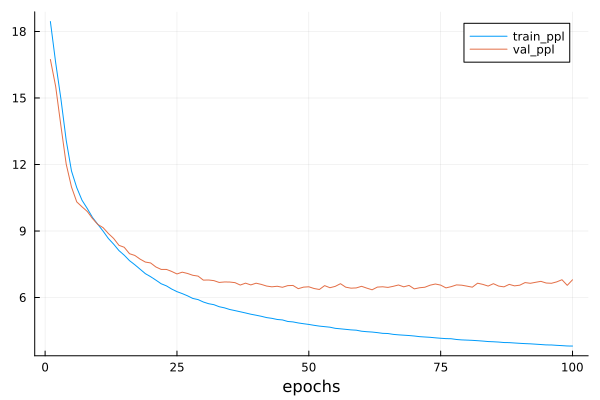

In [13]:
lstm_concise = LSTM(length(data.vocab) => num_hiddens; return_state = true)
model = RNNModelConcise(lstm_concise, num_hiddens, length(data.vocab)) |> f64
opt = Descent(1.)
trainer = Trainer(model, data, opt; max_epochs = 100, gpu = true, board_yscale = :identity, gradient_clip_val = 1.)
m = d2lai.fit(trainer);

In [14]:
prefix = "it has"
d2lai.prediction(prefix, m[1], data.vocab, 20; state = (zeros(num_hiddens), zeros(num_hiddens)))

"it has of the then the tim"

LSTMs are the prototypical latent variable autoregressive model with nontrivial state control.
Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. However, training LSTMs and other sequence models (such as GRUs) is quite costly because of the long range dependency of the sequence.
Later we will encounter alternative models such as Transformers that can be used in some cases.


## Summary

While LSTMs were published in 1997, 
they rose to great prominence 
with some victories in prediction competitions in the mid-2000s,
and became the dominant models for sequence learning from 2011 
until the rise of Transformer models, starting in 2017.
Even Tranformers owe some of their key ideas 
to architecture design innovations introduced by the LSTM.


LSTMs have three types of gates: 
input gates, forget gates, and output gates 
that control the flow of information.
The hidden layer output of LSTM includes the hidden state and the memory cell internal state. 
Only the hidden state is passed into the output layer while 
the memory cell internal state remains entirely internal.
LSTMs can alleviate vanishing and exploding gradients.



## Exercises

1. Adjust the hyperparameters and analyze their influence on running time, perplexity, and the output sequence.
1. How would you need to change the model to generate proper words rather than just sequences of characters?
1. Compare the computational cost for GRUs, LSTMs, and regular RNNs for a given hidden dimension. Pay special attention to the training and inference cost.
1. Since the candidate memory cell ensures that the value range is between $-1$ and $1$ by  using the $\tanh$ function, why does the hidden state need to use the $\tanh$ function again to ensure that the output value range is between $-1$ and $1$?
1. Implement an LSTM model for time series prediction rather than character sequence prediction.
